#### We run each simulation as follows and save the results in the form of pandas DataFrame

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
# here we update the setting for each experiment
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #Max trip distance in meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms.
params.platforms.base_fare = 1.4 #https://www.uber.com/global/en/price-estimate/
params.platforms.fare = float(1.2)#https://www.uber.com/global/en/price-estimate/
params.platforms.min_fare = float(4) # https://www.uber.com/global/en/price-estimate/
params.d2d.fuel_cost = 0.25 #euro/km #https://help.ubercarshare.com/hc/en-gb/articles/360022882131-Choosing-your-car-s-distance-rate  
params.platforms.comm_rate = float(0.20) 
params.platforms.discount = float(0.0) 
params.platforms.daily_marketing = False
params.platforms.incentive = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.18
params.d2d.B_Marketing = 0.02
params.d2d.diffusion_speed = 10/100 # for marketing and word of mouth
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000 # number of passengers
params.nV = 200 # number of drivers
params.nD = 400 # number of simulation days
params.simTime = 4 # based on amsterdam uber report
params.d2d.res_wage = params.simTime*11.16 #https://www.government.nl/topics/minimum-wage/amount-of-the-hourly-minimum-wage

In [ ]:
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

#### Figure 2: This study’s research gap and contribution 

In [12]:
# import data
nyc = pd.read_csv('AAMAS2024/Uber_NYC_2012-2022.csv')
nyc.date = nyc.apply(lambda row: pd.Timestamp(row.date), axis=1)
nyc.at[0,'date'] = pd.Timestamp('2012-07-01')

mi = pd.read_csv('AAMAS2024/Uber_Miami.csv')
mi.date = mi.apply(lambda row: pd.Timestamp(row.date), axis=1)

sea = pd.read_csv('AAMAS2024/Uber_Seattle.csv')
sea.date = sea.apply(lambda row: pd.Timestamp(row.date), axis=1)

ams = pd.read_csv('AAMAS2024/Uber_Ams_2016-2022.csv')
ams.date = ams.apply(lambda row: pd.Timestamp(row.date), axis=1)

arjan = pd.read_csv('AAMAS2024/Arjan_supply.csv')
arjan.date = arjan.apply(lambda row: pd.Timestamp(row.date), axis=1)

djavadian = pd.read_csv('AAMAS2024/Djavadian_supply.csv')
djavadian.date = djavadian.apply(lambda row: pd.Timestamp(row.date), axis=1)

ertz = pd.read_csv('AAMAS2024/Ertz_supply.csv')
ertz.date = ertz.apply(lambda row: pd.Timestamp(row.date), axis=1)

nyc = nyc.loc[0:88]
ertz = ertz.loc[2:29]
ams = ams[:47]
yms = pd.read_csv('AAMAS2024/baseline_supply1.csv')
yms = yms[0:360]

In [13]:
import datetime

base = pd.Timestamp('2012-07-01')
n_days = 360
step = 7.6 #7.6
# calculating timestamps for the next 10 days
timestamp_list = [base + datetime.timedelta(days=step*x) for x in range(n_days)]
me = pd.DataFrame()
me['supply_share'] = yms.OUT
me['date'] = timestamp_list

In [14]:
def smooth(y,w=41,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

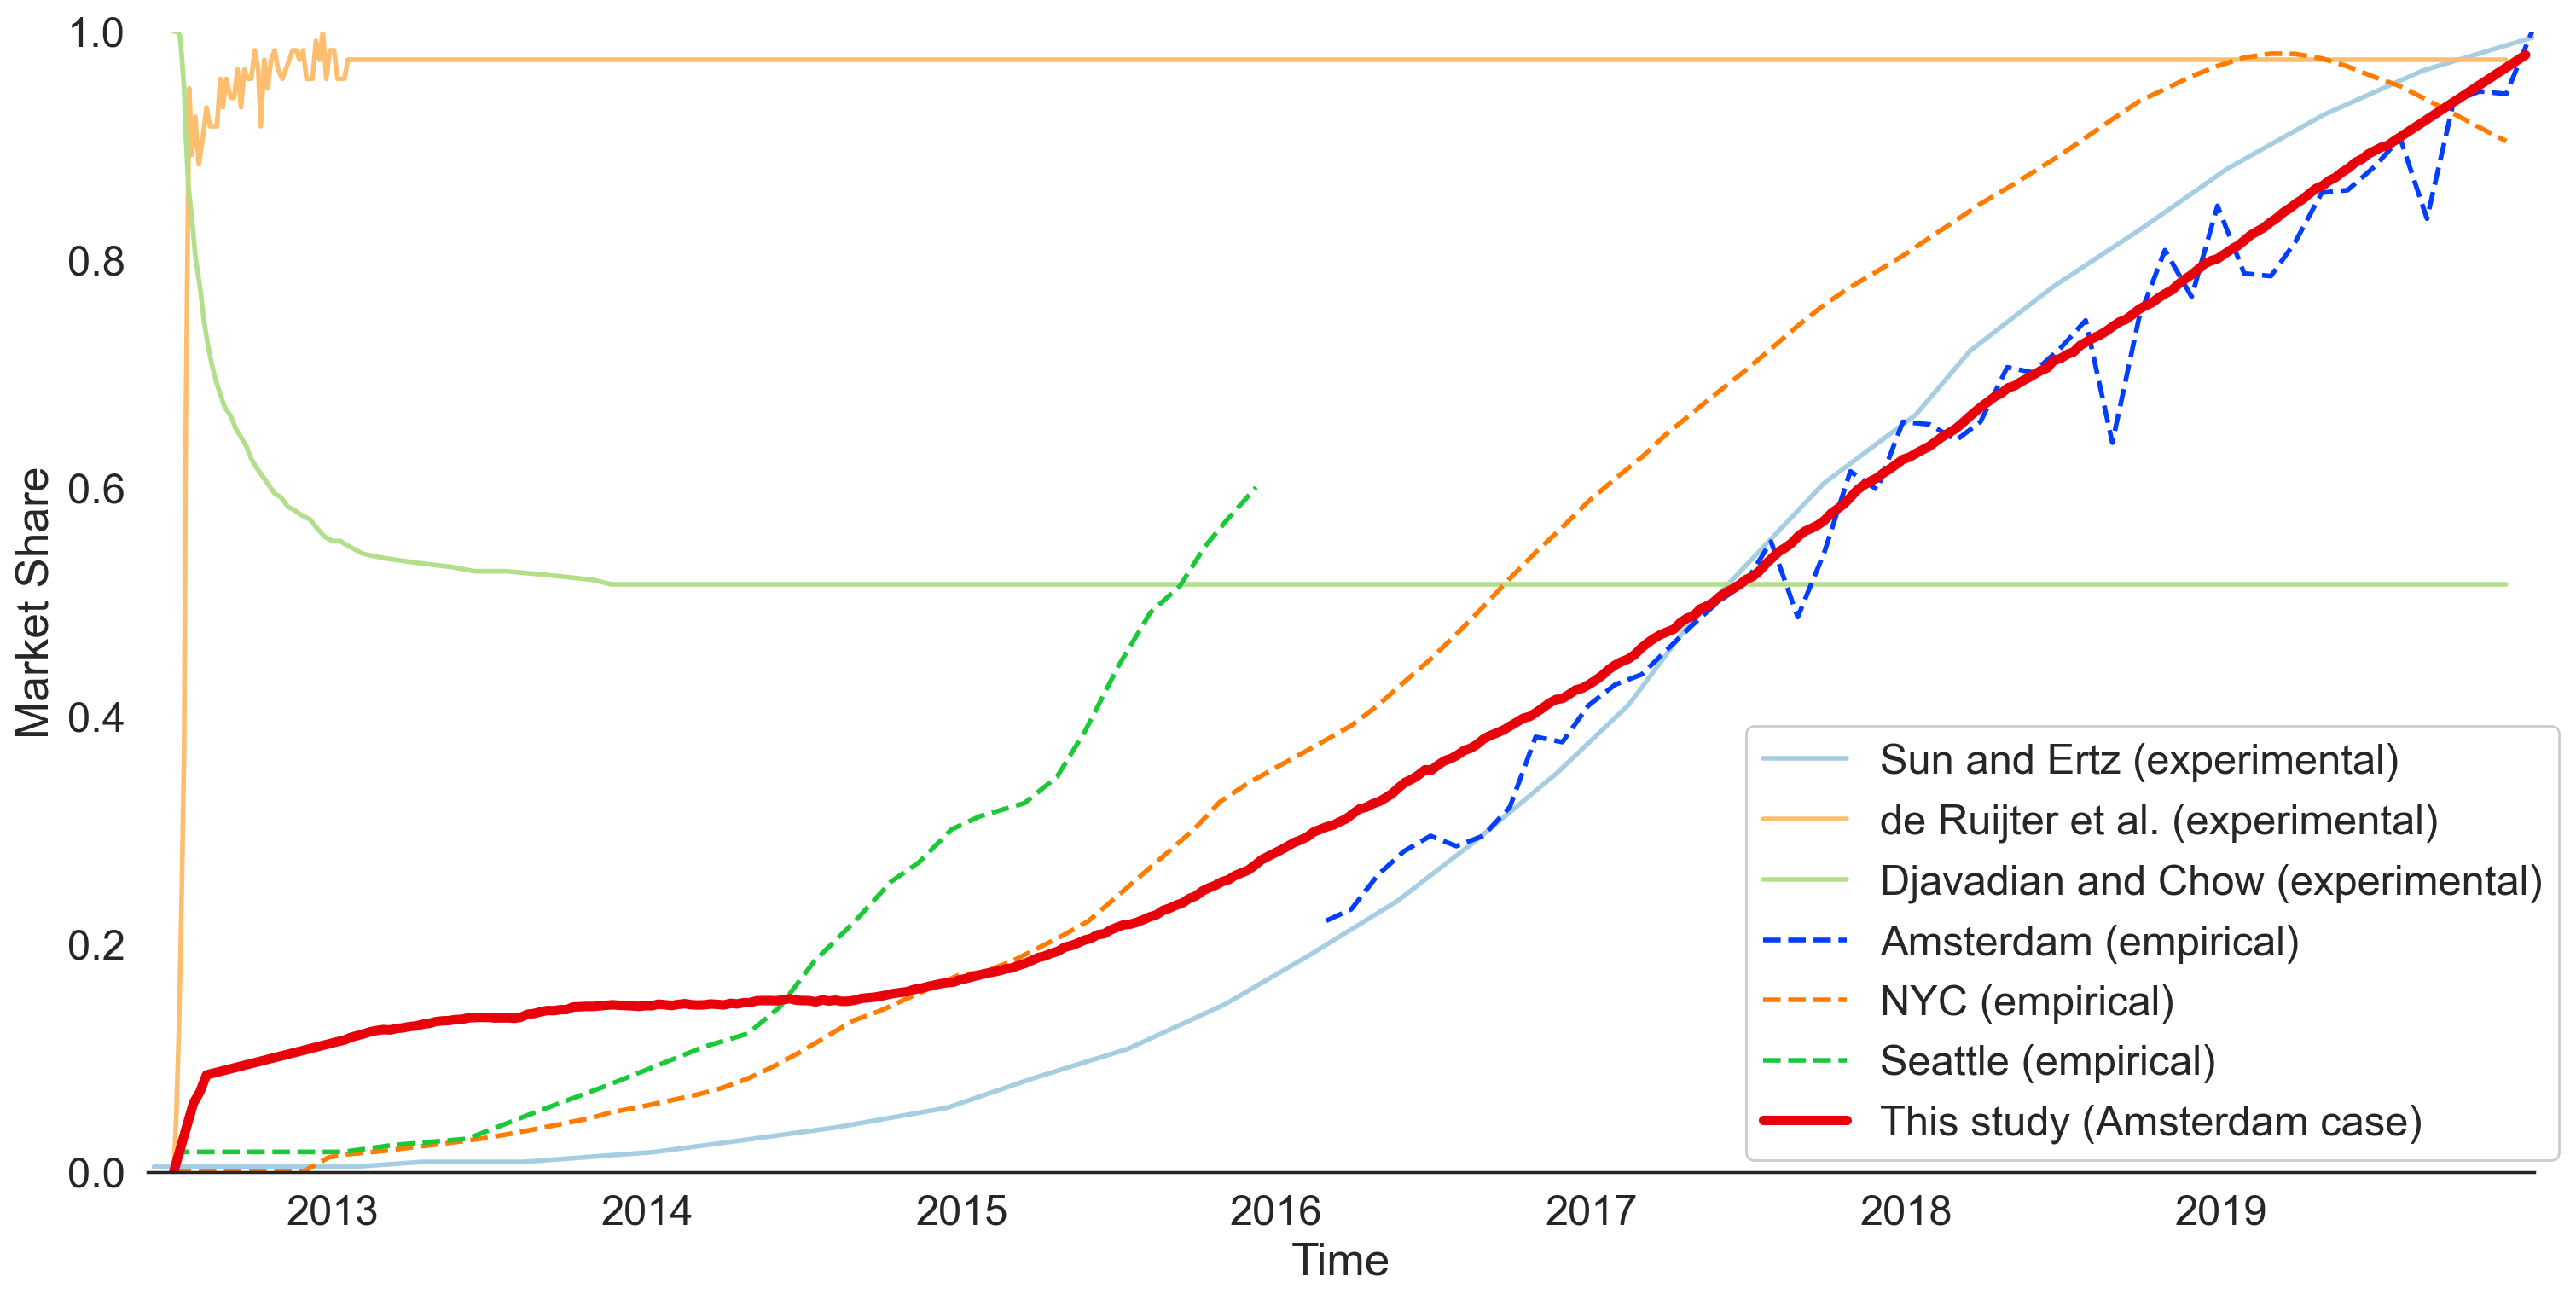

In [15]:
# Here we use min-max scaling or normalization: https://www.linkedin.com/advice/1/what-pros-cons-different-scaling-methods-data-normalization#:~:text=Data%20normalization%20and%20scaling%20can%20be%20achieved%20through%20several%20methods,dividing%20by%20the%20maximum%20value.

sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, figsize=(16,8))
sns.despine(left=True)

bright = sns.color_palette("bright")
blues = sns.color_palette("Blues")
greys = sns.color_palette("Greys")
paired = sns.color_palette("Paired")
#State-of-art-----------------------------------------------------------------------
ertz_max = ertz.supply_share.max()
ertz_last_v = ertz.supply_share[len(ertz)-1]
sns.lineplot(x=ertz.loc[0:29].date, y=ertz.loc[0:29].supply_share/ertz_max,lw=2, label = 'Sun and Ertz (experimental)', color=paired[0], linestyle = 'solid')
# sns.lineplot(x=ertz.loc[30:].date, y=ertz.loc[30:].supply_share/ertz_max,lw=1, color='C2', marker = '.')

arjan_max = arjan.supply_share.max()
arjan_last_v = arjan.supply_share[len(arjan)-1]
sns.lineplot(x=arjan.date, y=arjan.supply_share/arjan_max, lw=2, label = 'de Ruijter et al. (experimental)', color=paired[6], linestyle = 'solid')
aj_date = nyc.loc[6:].date; aj_date[6] = pd.Timestamp('2013-01-19')
sns.lineplot(x=aj_date, y=arjan_last_v/arjan_max, lw=2, color=paired[6], linestyle = 'solid')

djavadian_max = djavadian.supply_share.max()
djavadian_last_v = djavadian.supply_share[len(djavadian)-1]
sns.lineplot(x=djavadian.date, y=djavadian.supply_share/djavadian_max,lw=2, label = 'Djavadian and Chow (experimental)', color=paired[2], linestyle = 'solid')
dj_date = nyc.loc[16:].date; dj_date[16] = pd.Timestamp('2013-11-20')
sns.lineplot(x=dj_date, y=djavadian_last_v/djavadian_max,lw=2, color=paired[2], linestyle = 'solid')

#Empirical-----------------------------------------------------------------------
ams_max = ams['Number_of_drivers'].max()
ams_y =ams['Number_of_drivers']# smooth(ams['Number_of_drivers'], w=9)
ams_y = [0 if math.isnan(y) else y/ams_max for y in ams_y]
ams_y[0] = 0.22; ams_y[1] = 0.23
sns.lineplot(x=ams.date, y=ams_y,lw=2, label = 'Amsterdam (empirical)', color=bright[0], linestyle = 'dashed')

nyc_max = nyc['Unique Dispatched Vehicles'].max()
nyc_smoothed = smooth(nyc['Unique Dispatched Vehicles'], w=9)
nyc_y = nyc_smoothed[0:89]+list(nyc[89:97]['Unique Dispatched Vehicles'])+nyc_smoothed[97:]
nyc_y = [0 if math.isnan(y) else y/nyc_max for y in nyc_y]
# nyc_x = [x for x in range(1,len(nyc_y)+1)]
sns.lineplot(x=nyc.date, y=nyc_y,lw=2, label = 'NYC (empirical)', color=bright[1], linestyle = 'dashed')

sea_max = sea.supply_share.max()
sns.lineplot(x=sea.date, y=0.6*sea.supply_share/sea_max,lw=2, label = 'Seattle (empirical)', color=bright[2], linestyle = 'dashed')
#Us-----------------------------------------------------------------------
me_max = me.supply_share.max()
me_last_v = me.supply_share[len(me)-1]
yme = me.supply_share/me_max
yme = smooth(yme)
yme[0:5] = [0,0.02,0.04,0.06,0.07]
sns.lineplot(x=me.date, y=yme,lw=4, label = 'This study (Amsterdam case)', color=bright[3])

ax.set(xlabel='Time', ylabel='Market Share',xlim=(pd.Timestamp('2012-06-01 00:00:00')
,pd.Timestamp('2019-12-30 00:00:00')), ylim=(0,1))
# labels = ['Ghasemi and Kucharski','NYC (Empirical)', 'Amsterdam (Empirical)', 'Miami (Empirical)', 'Djavadian and Chow', 'Sun and Ertz']
ax.legend(frameon=True,framealpha=1, loc=(0.67,0.01))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)

plt.tight_layout()
# plt.savefig('Fig2.png')

#### Figure 3:  Temporal evolution of choice probability (red) and three components of utility for four sampled agents with various temporal trajectories

In [33]:
pax3 = pd.read_csv('AAMAS2024/pax3.csv')
pax8 = pd.read_csv('AAMAS2024/pax8.csv')
driver2 = pd.read_csv('AAMAS2024/driver2.csv')
driver37 = pd.read_csv('AAMAS2024/driver37.csv')

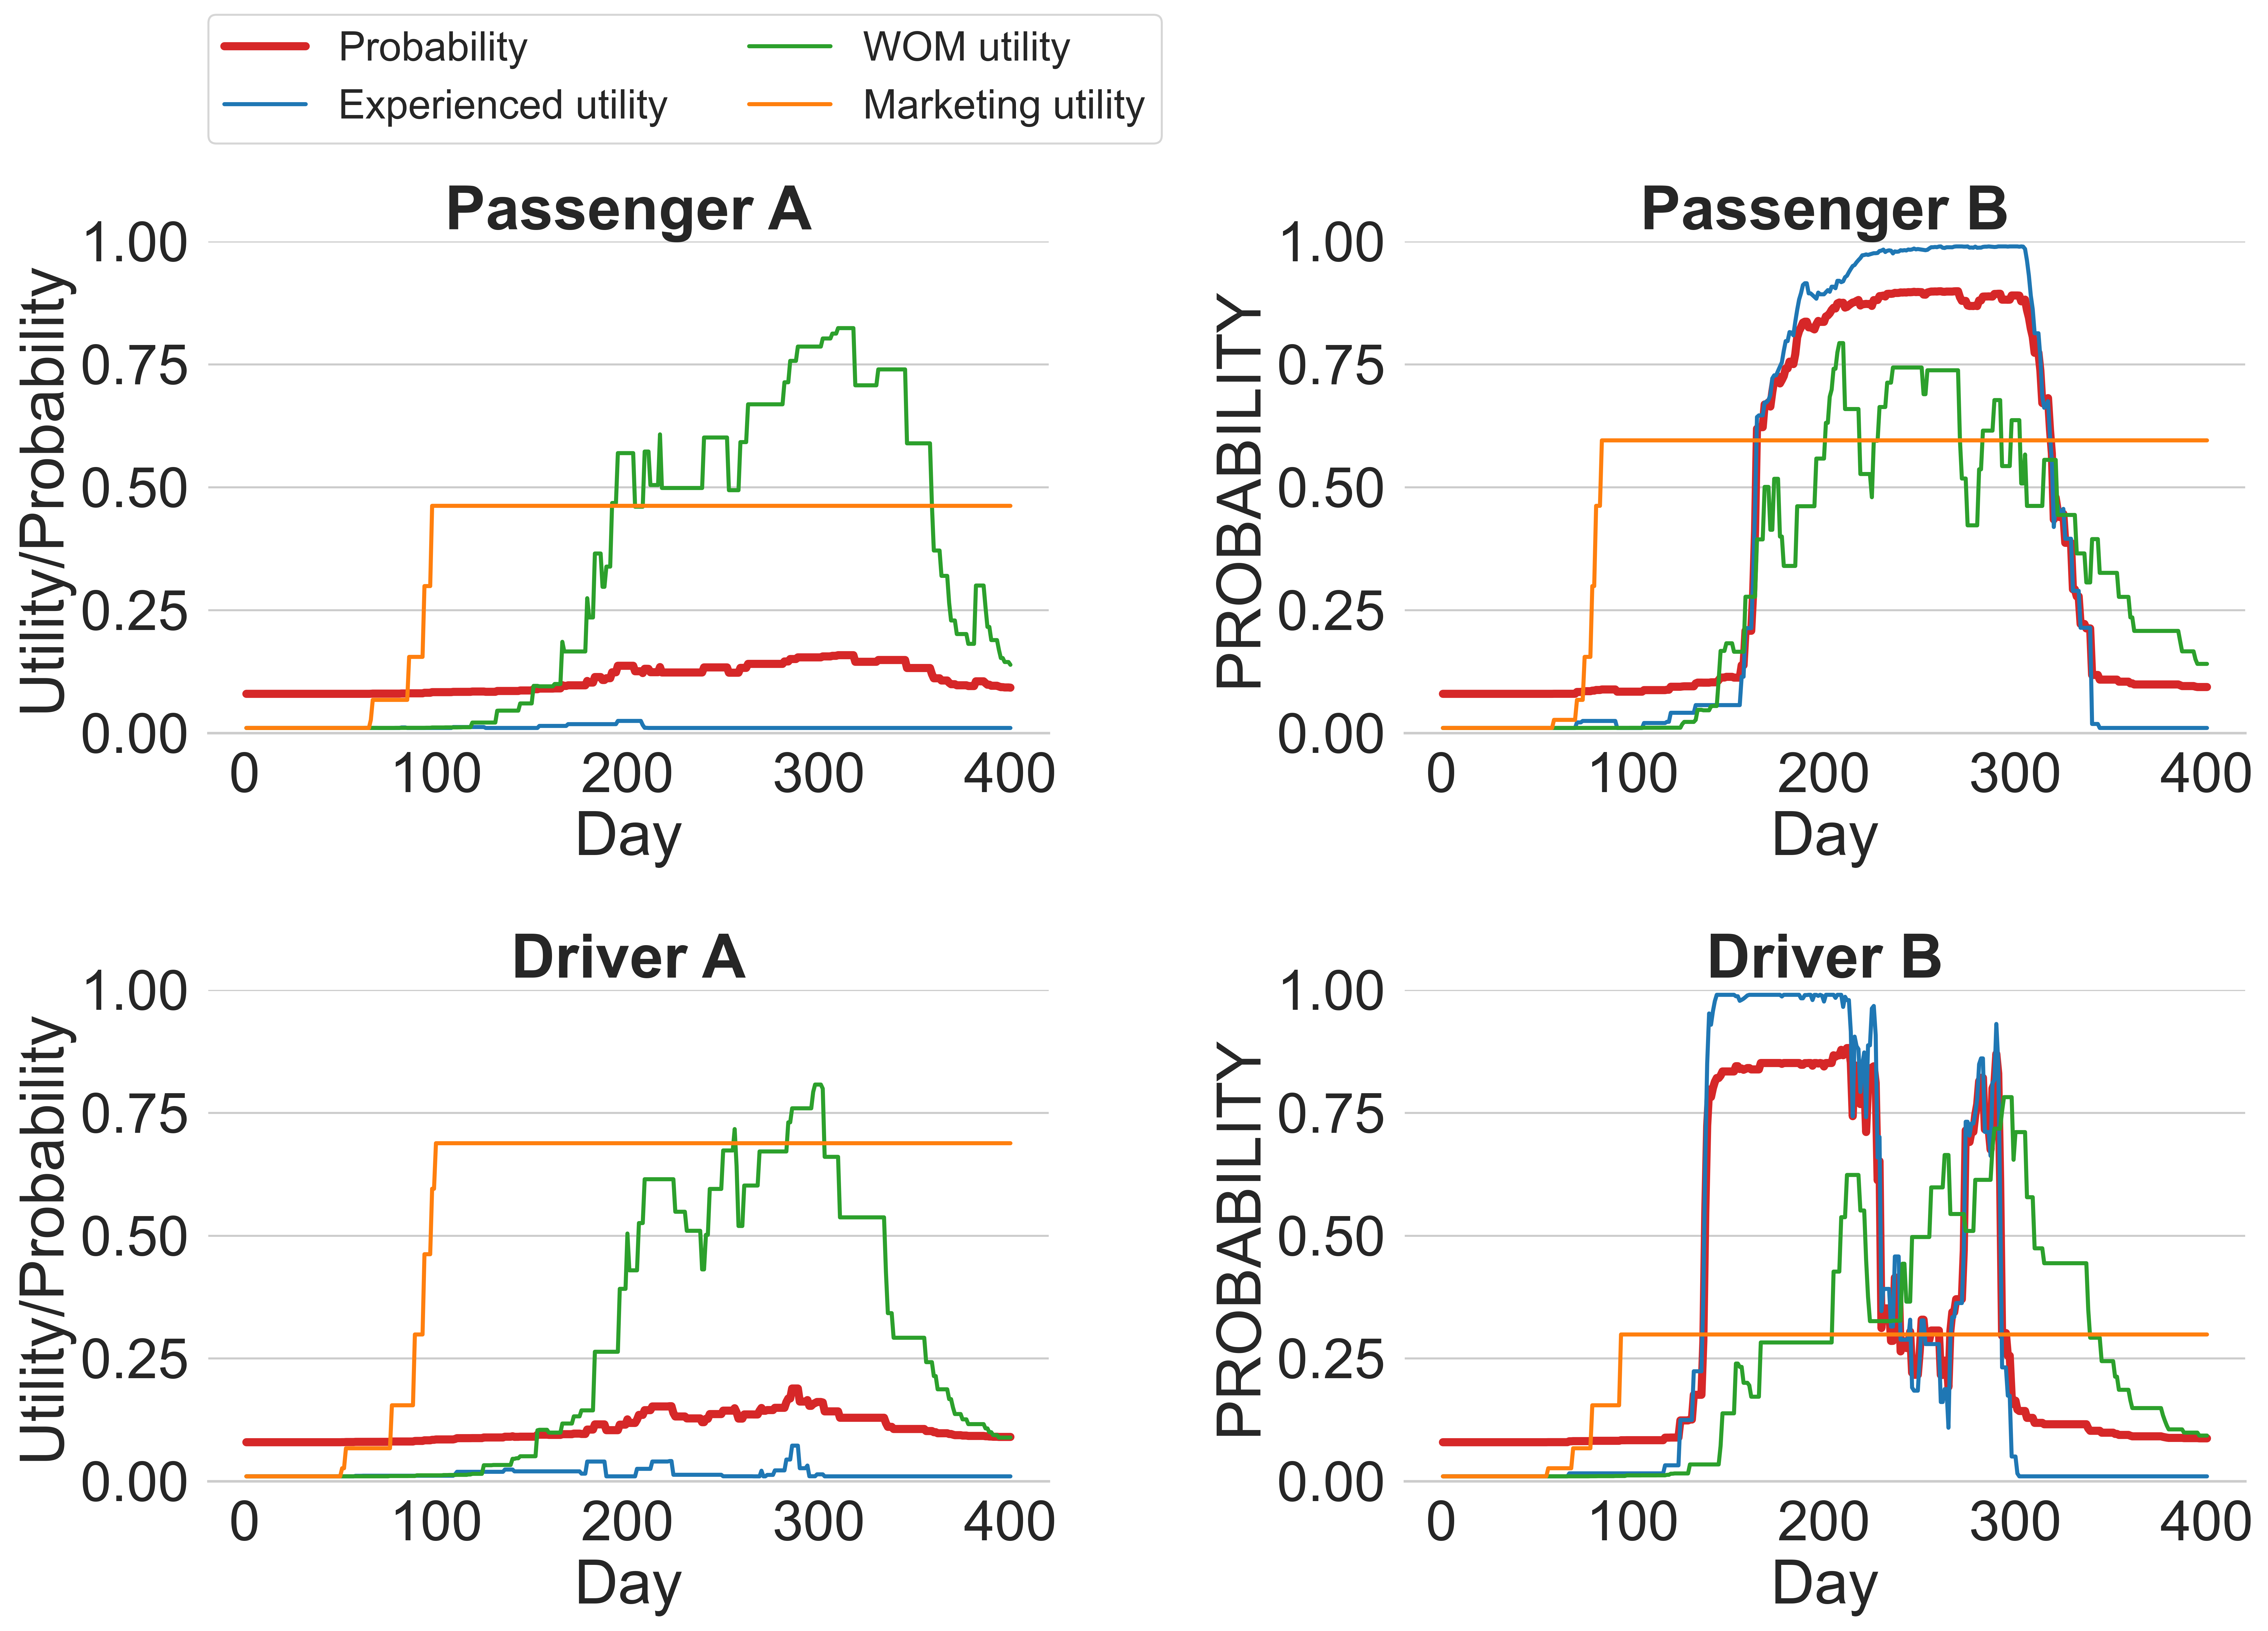

In [36]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
sns.despine(left=True)

ids = [3,8,2,37]
agent = [pax3,pax8,driver2,driver37]

n = 0
nD = 400

for n in range(0,4):
    
    x = [i for i in range(1,nD+1)]
    if n<2:
        sns.lineplot(x=x, y=agent[n].PROBABILITY, label = 'Probability', color='C3', linewidth=4, ax=ax[0,n])
        sns.lineplot(x=x, y=agent[n].EXPERIENCE_U, label = 'Experienced utility', color='C0', lw=2, ax=ax[0,n])#, marker='o')
        sns.lineplot(x=x, y=agent[n].WOM_U, label = 'WOM utility', color='C2',lw=2, ax=ax[0,n])#, marker='o')
        sns.lineplot(x=x, y=agent[n].MARKETING_U, label = 'Marketing utility', color='C1',lw=2, ax=ax[0,n])#, marker='o')

        ax[0,n].set(xlabel='Day', ylim=(0,1))
        ax[0,n].grid(axis='x')
        
    else:
        sns.lineplot(x=x, y=agent[n].PROBABILITY, label = 'Probability', color='C3', linewidth=4, ax=ax[1,n-2])
        sns.lineplot(x=x, y=agent[n].EXPERIENCE_U, label = 'Experienced utility', color='C0', lw=2, ax=ax[1,n-2])#, marker='o')
        sns.lineplot(x=x, y=agent[n].WOM_U, label = 'WOM utility', color='C2',lw=2, ax=ax[1,n-2])#, marker='o')
        sns.lineplot(x=x, y=agent[n].MARKETING_U, label = 'Marketing utility', color='C1',lw=2, ax=ax[1,n-2])#, marker='o')
        ax[1,n-2].set(xlabel='Day', ylim=(0,1))
        ax[1,n-2].grid(axis='x')
    
ax[0,0].legend(loc=(0,1.2), frameon=True, ncol=2, fontsize=20)
ax[0,0].set(ylabel='Utility/Probability'); ax[1,0].set(ylabel='Utility/Probability')
ax[0,1].get_legend().set_visible(False);ax[1,0].get_legend().set_visible(False);ax[1,1].get_legend().set_visible(False)
ax[0,0].set_title('Passenger A',fontweight='bold');ax[0,1].set_title('Passenger B',fontweight='bold');ax[1,0].set_title('Driver A',fontweight='bold');ax[1,1].set_title('Driver B',fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig3.png')

#### Figure 4: Six stages and 400 days of the evolution of the market entry strategy in Amsterdam 

In [37]:
demand = pd.read_csv('AAMAS2024/six-stage_demand.csv')
supply = pd.read_csv('AAMAS2024/six-stage_supply.csv')

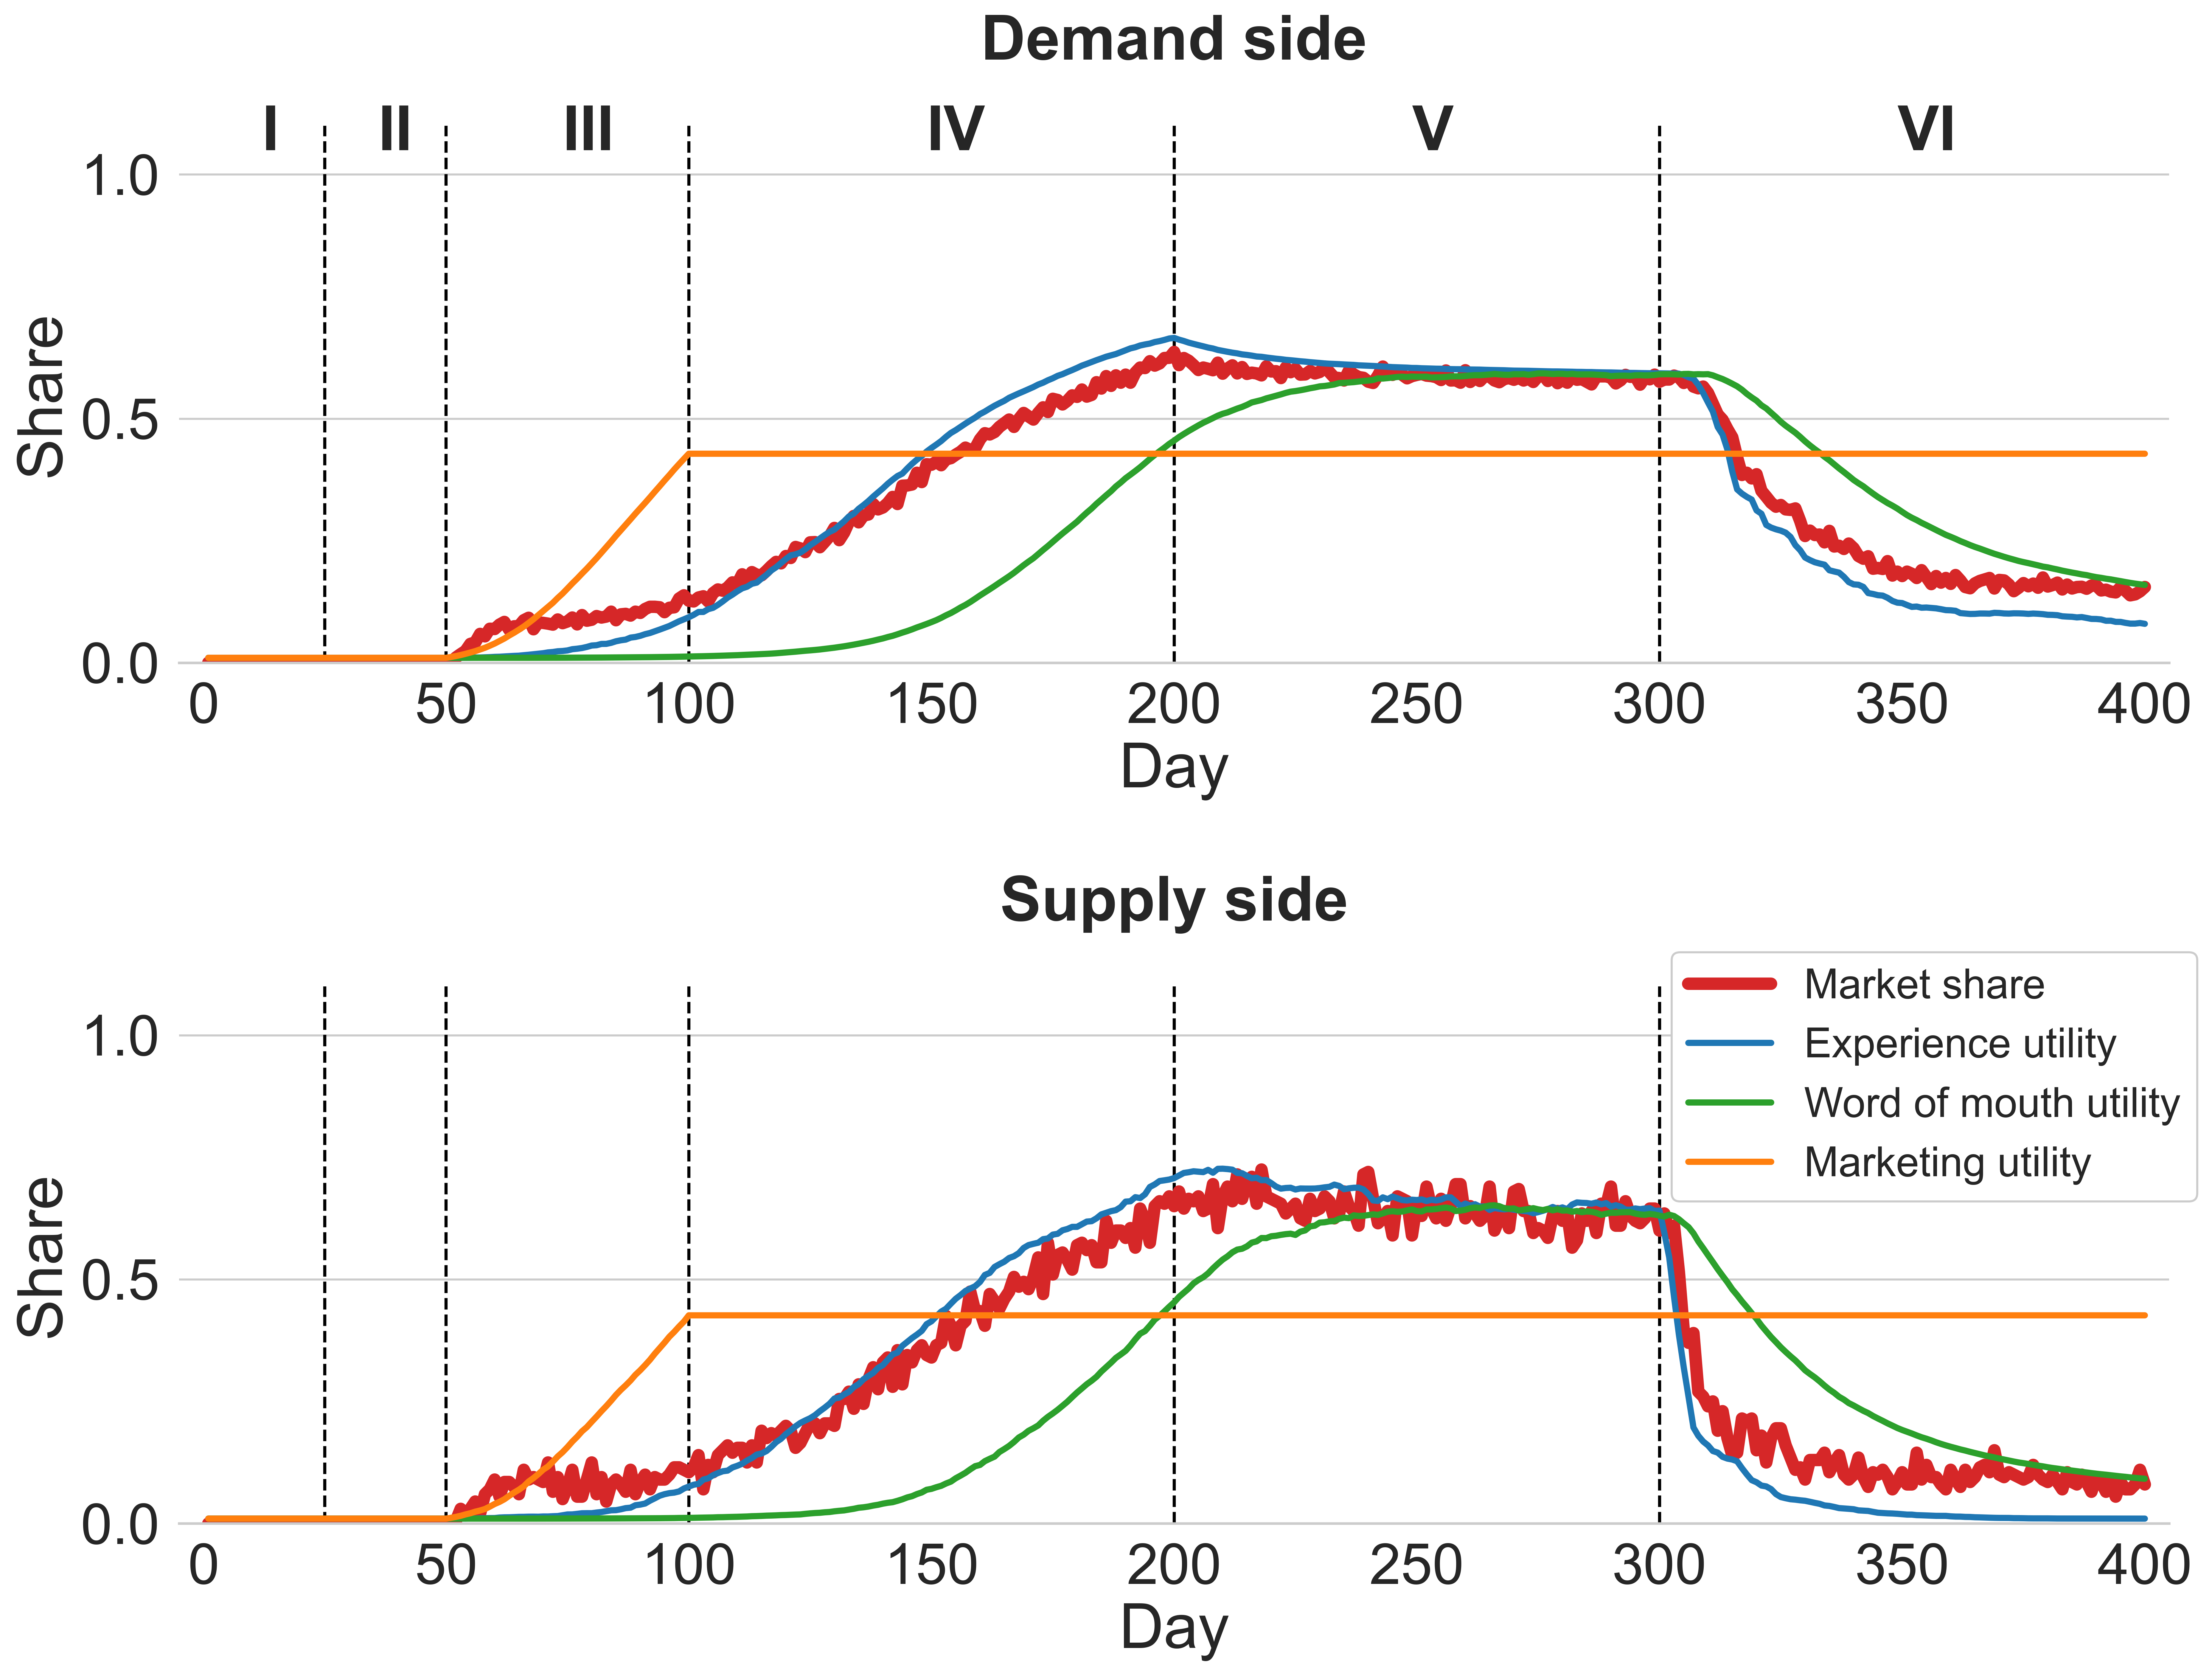

In [48]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
sns.despine(left=True)

nD = 400
nP = 2000
nV = 200
data = [demand, supply]

for ax_n in [0,1]:
    if ax_n==0:
        n=nP
    else:
        n=nV
    lx = [i for i in range(1,nD+1)]
    sns.lineplot(x=lx, y=data[ax_n].OUT/n, label = 'Market share', color='C3', lw=6, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=data[ax_n].EXPERIENCE_U, label = 'Experience utility', color='C0', lw=3, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=data[ax_n].WOM_U, label = 'Word of mouth utility', color='C2', lw=3, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=data[ax_n].MARKETING_U, label = 'Marketing utility', color='C1', lw=3, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center', x=0.5, y=1.1);ax[1].set_title('Supply side',fontweight='bold', loc='center', x=0.5, y=1.1)
ax[1].legend(frameon=True,framealpha=1, loc=(0.75,0.6), fontsize=20)#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig4.png')

#### Figure 5:  Evolution of key performance indicators for the supply (top) and demand (bottom)

In [57]:
def smooth(y,w=11,o=1,d=51):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

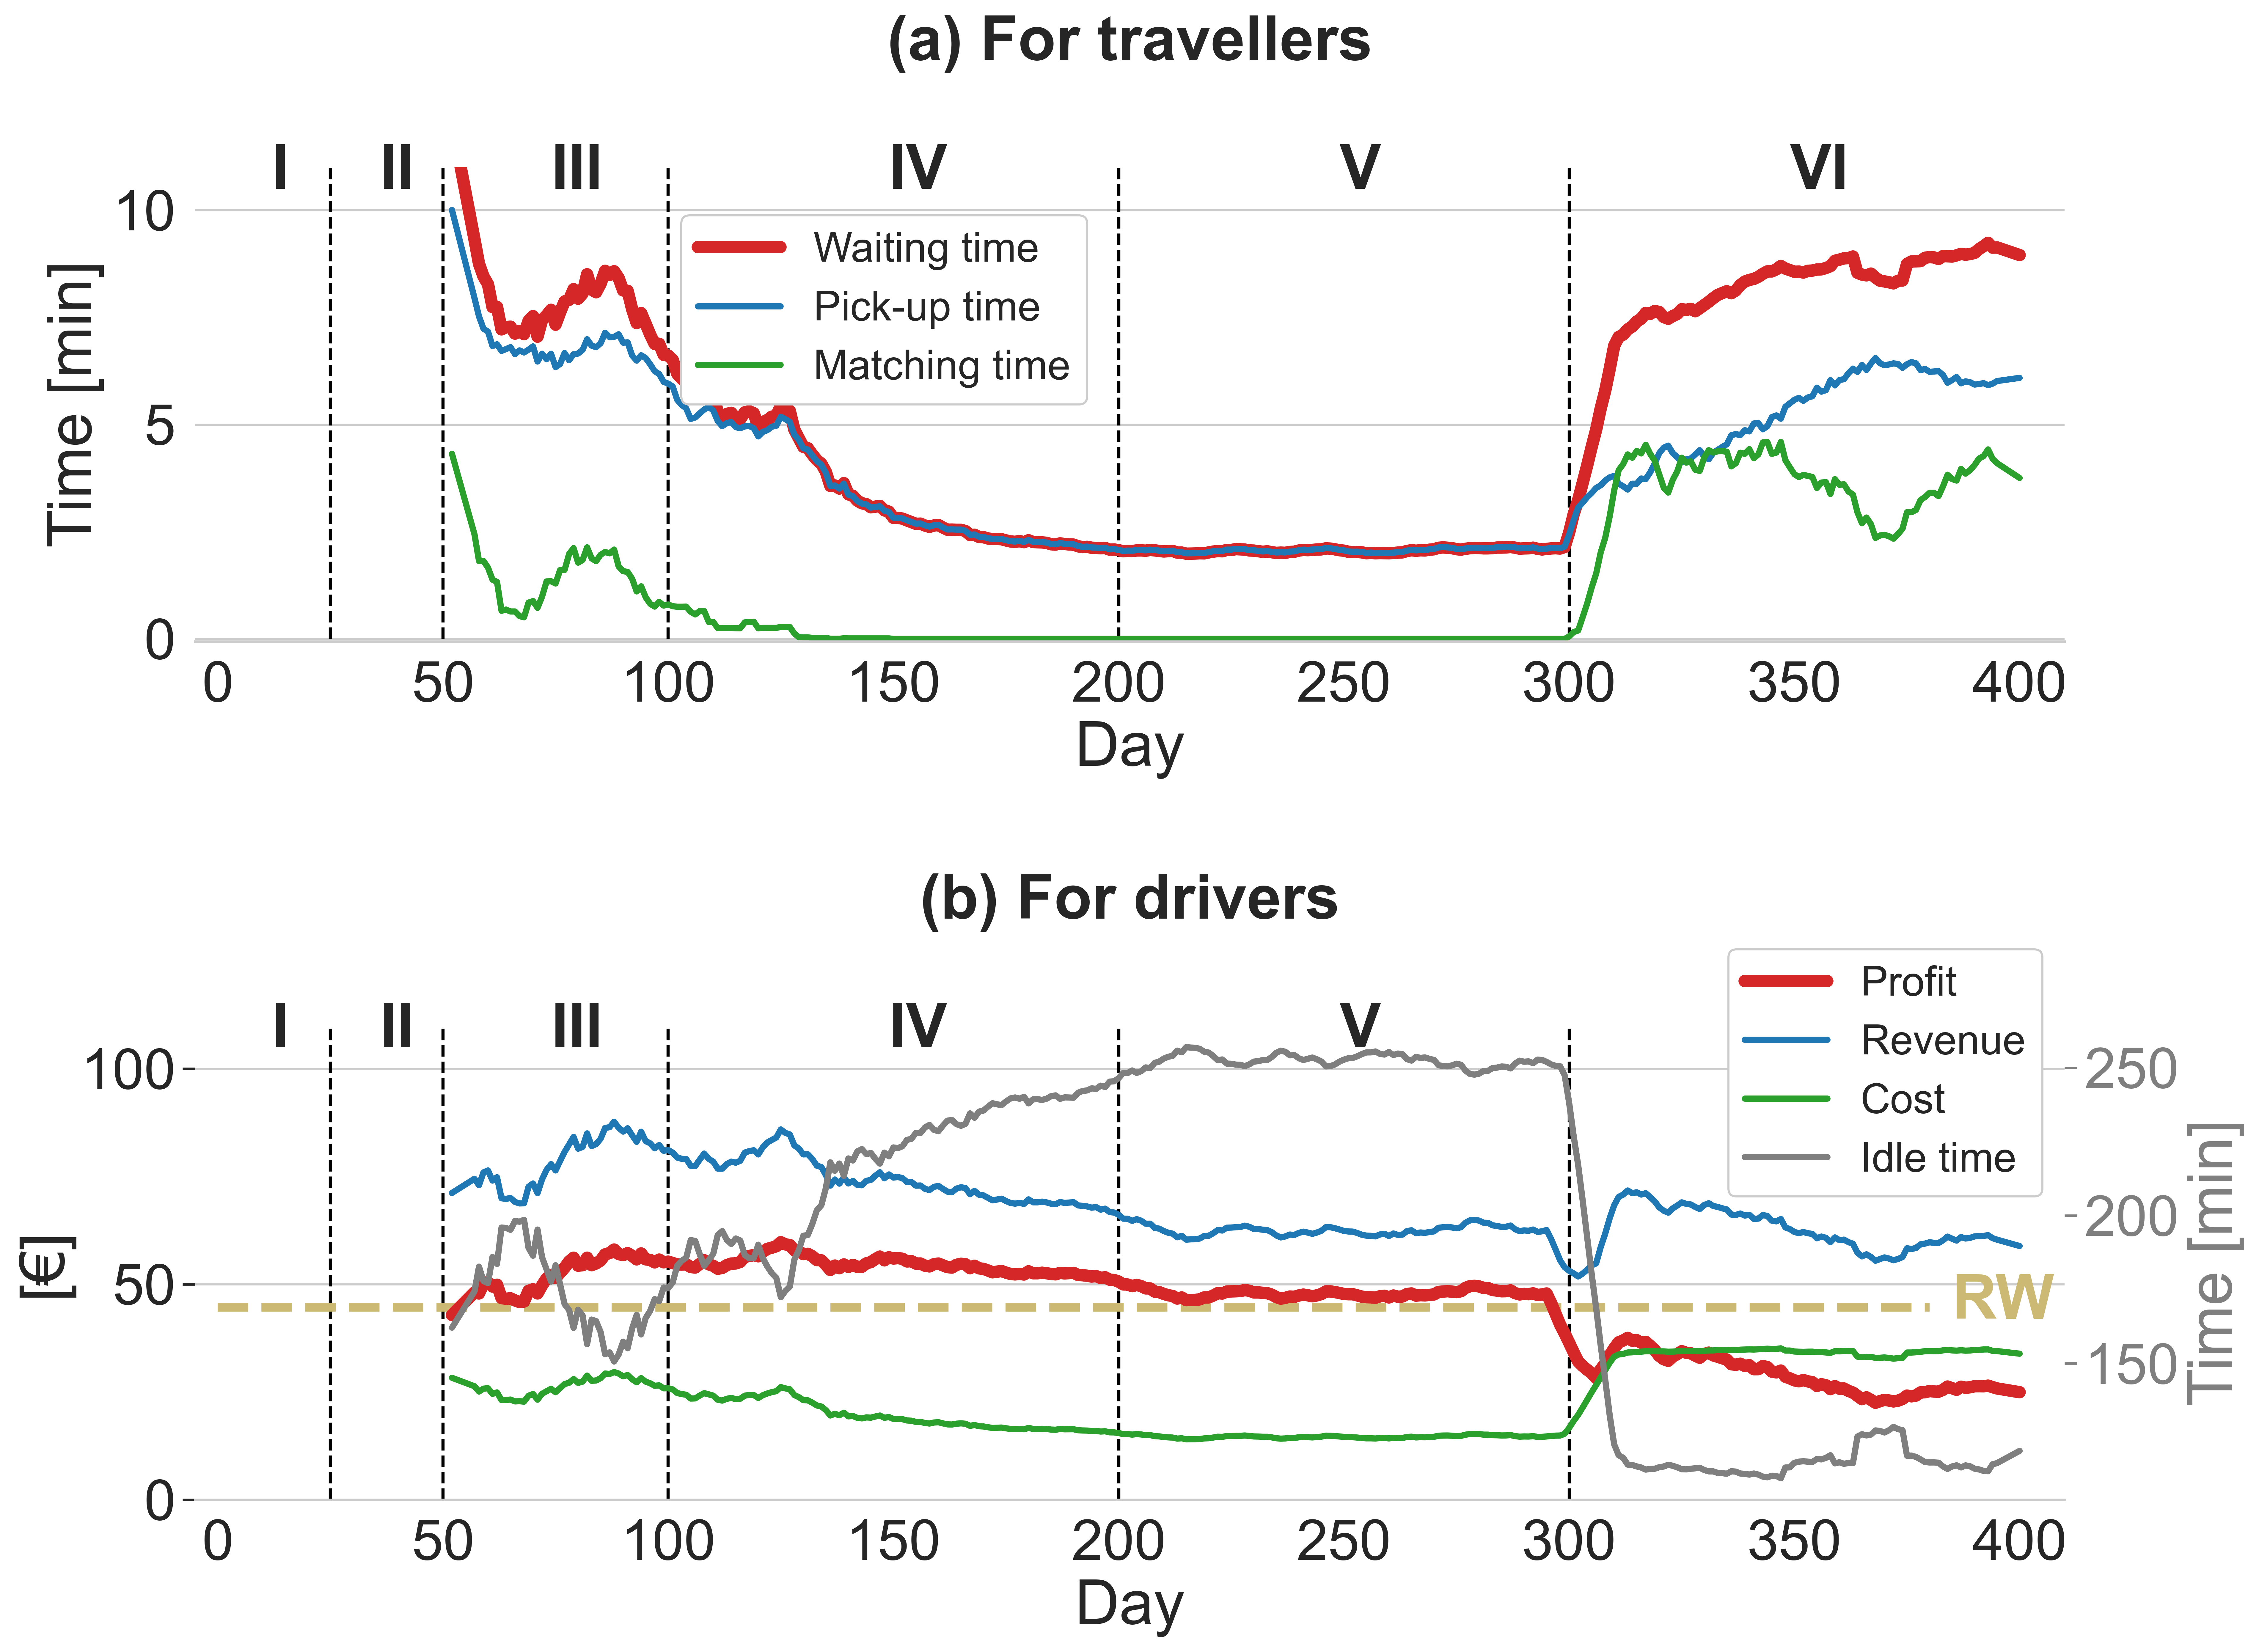

In [65]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(nrows=2, figsize=(16,12))
sns.despine(left=True)

x = [i for i in range(1,nD+1)]
sns.lineplot(x=x, y=smooth(data[0].ACTUAL_WT), label = 'Waiting time', color='C3',lw=6, ax=ax[0])#, marker='o')
pick_up_time = data[1].ARRIVES_AT_PICKUP/(data[1].nRIDES*60)
sns.lineplot(x=x, y=smooth(pick_up_time), label = 'Pick-up time', color='C0',lw=3, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=smooth(data[0].MATCHING_T), label = 'Matching time', color='C2',lw=3, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=smooth(data[1].ACTUAL_INC), label = 'Profit', color='C3',lw=6, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=smooth(data[1].REVENUE), label = 'Revenue', color='C0',lw=3, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=smooth(data[1].COST), label = 'Cost', color='C2',lw=3, ax=ax[1])#, marker='o')ax.twinx()
ax11 = ax[1].twinx()
sns.lineplot(x=x, y=smooth(data[1].IDLE_TIME/60), label = 'Idle time', color='C7',lw=3, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.82,0.64), fontsize=20)
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i].grid(axis='x')

ax[0].vlines([25, 50, 100, 200, 300], 0, 11, linestyles='dashed', colors='black')
ax[1].vlines([25, 50, 100, 200, 300], 0, 110, linestyles='dashed', colors='black')
ax[1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1].annotate('RW', xy =(385,42), fontweight='bold', color='y')

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,10.5),(36,10.5),(74,10.5),(149,10.5),(249,10.5),(349,10.5)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')
for i in range(0,6):
    coords = [(12,105),(36,105),(74,105),(149,105),(249,105),(349,105)]
    ax[1].annotate(value[i], xy =coords[i], fontweight='bold')    
    
ax[0].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,410)); ax[1].set(xlabel='Day', ylabel='[€]', ylim=(0,110),xlim=(-5,410))
ax[0].legend(loc=(0.26,0.5),framealpha=1, fontsize=20)
sns.despine(left=True)

ax[0].set_title('(a) For travellers',fontweight='bold', x=0.5, y=1.2)
ax[1].set_title('(b) For drivers',fontweight='bold', x=0.5, y=1.2)

plt.tight_layout()
# plt.savefig('Fig5.png')

#### Figure 6: Sensitivity analysis of the proposed model

In [91]:
import datetime
import matplotlib.dates as mdates

nD = 500
base = pd.Timestamp('2012-07-01')
n_days = nD
step = 7.6 #7.6
timestamp = [base + datetime.timedelta(days=step*x) for x in range(n_days)]

df_d = pd.read_csv('data/dataframes/baseline_demand1.csv'); df_d['date'] = timestamp
df_s = pd.read_csv('data/dataframes/baseline_supply1.csv'); df_s['date'] = timestamp

df_c30_d = pd.read_csv('data/dataframes/comm_30_demand1.csv'); df_c30_d['date'] = timestamp
df_c30_s = pd.read_csv('data/dataframes/comm_30_supply1.csv'); df_c30_s['date'] = timestamp

df_c10_d = pd.read_csv('data/dataframes/comm_10_demand1.csv'); df_c10_d['date'] = timestamp
df_c10_s = pd.read_csv('data/dataframes/comm_10_supply1.csv'); df_c10_s['date'] = timestamp

df_f18_d = pd.read_csv('data/dataframes/fare_1.8_demand1.csv'); df_f18_d['date'] = timestamp
df_f18_s = pd.read_csv('data/dataframes/fare_1.8_supply1.csv'); df_f18_s['date'] = timestamp

df_f06_d = pd.read_csv('data/dataframes/fare_0.6_demand1.csv'); df_f06_d['date'] = timestamp
df_f06_s = pd.read_csv('data/dataframes/fare_0.6_supply1.csv'); df_f06_s['date'] = timestamp

df_disc50_d = pd.read_csv('data/dataframes/disc_50%_demand1.csv'); df_disc50_d['date'] = timestamp
df_disc50_s = pd.read_csv('data/dataframes/disc_50%_supply1.csv'); df_disc50_s['date'] = timestamp

df_incen50_d = pd.read_csv('data/dataframes/incen_50%_demand1.csv'); df_incen50_d['date'] = timestamp
df_incen50_s = pd.read_csv('data/dataframes/incen_50%_supply1.csv'); df_incen50_s['date'] = timestamp

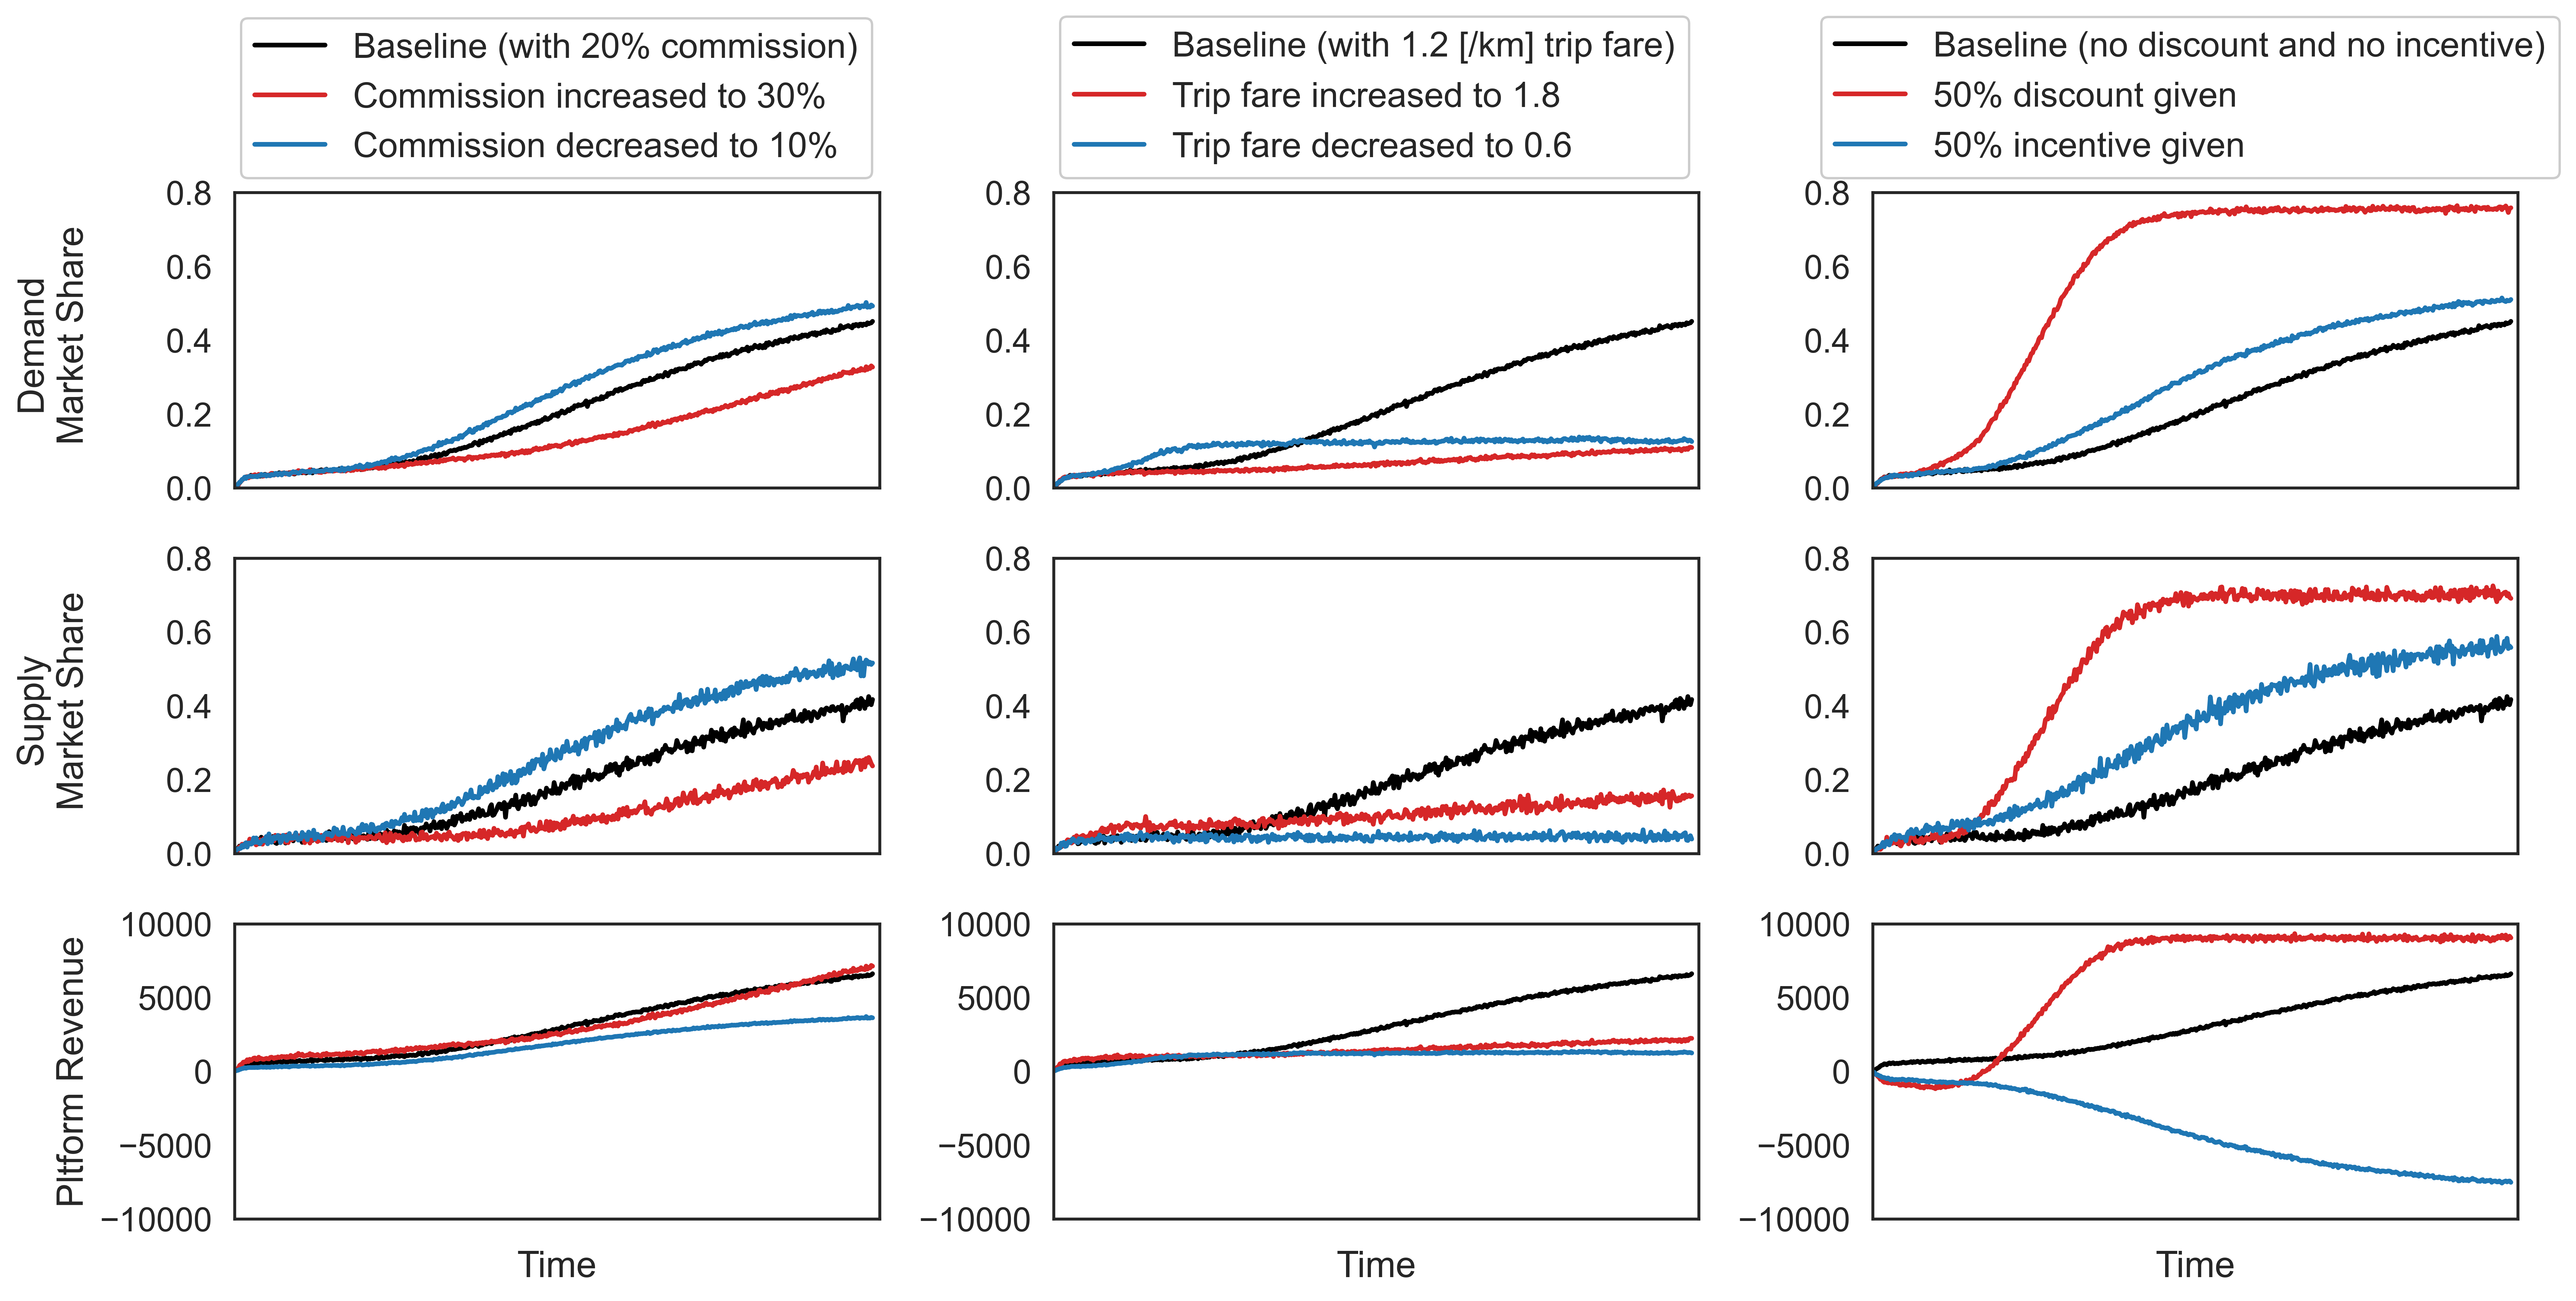

In [96]:
# with replicationssnoitacilperriment


# with sample for each experiment
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('white')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
# sns.despine(left=True)

pallete = sns.color_palette("tab10")
c2=pallete[3]; c3=pallete[0]
lw = 2
# c2='darkred'; c3='darkblue'
start_date = pd.Timestamp('2012-07-01 00:00:00'); end_date = pd.Timestamp('2022-12-30 00:00:00')


for row in range(0,3):
    
    lx = [i for i in range(1,nD+1)]
    
    if row==0:
        n=10000; label='Demand side'
        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        # sns.lineplot(data=reps('baseline_demand'), x='date', y='OUT', label = 'Baseline (with 20% commission)', color='black', lw=0.5, ax=ax[row][0])
        sns.lineplot(x=df_c30_d.date, y=df_c30_d.OUT/n, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_d.date, y=df_c10_d.OUT/n, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (with 1.2 [/km] trip fare)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_d.date, y=df_f18_d.OUT/n, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_d.date, y=df_f06_d.OUT/n, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])

        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_d.date, y=df_disc50_d.OUT/n, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_incen50_d.date, y=df_incen50_d.OUT/n, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
    elif row==1:
        n = 1000; label='Supply side'
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c30_s.date, y=df_c30_s.OUT/n, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_s.date, y=df_c10_s.OUT/n, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (with 1.2 [/km] trip fare)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_s.date, y=df_f18_s.OUT/n, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_s.date, y=df_f06_s.OUT/n, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])
    
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_s.date, y=df_disc50_s.OUT/n, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_incen50_s.date, y=df_incen50_s.OUT/n, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
    elif row==2:
        n = 1000; label='Platform'
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c30_d.date, y=df_c30_d.OUT*df_c30_d.plat_revenue, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_d.date, y=df_c10_d.OUT*df_c10_d.plat_revenue, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_d.date, y=df_f18_d.OUT*df_f18_d.plat_revenue, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_d.date, y=df_f06_d.OUT*df_f06_d.plat_revenue, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])
    
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_d.date, y=df_disc50_d.OUT*df_disc50_d.plat_revenue, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        x = df_incen50_d.OUT*df_incen50_d.plat_revenue
        r = (x*100)/20; r = (r*80/100)*0.5; p = x-r
        sns.lineplot(x=df_incen50_d.date, y=p, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
        
    for col in range(0,3):
        ax[row][col].set(xlabel='', ylabel=None,xlim=(start_date, end_date), ylim=(0,0.8))
        ax[row][col].set(xlabel='', ylabel=None,xlim=(start_date, end_date), ylim=(0,0.8))
        ax[row][col].set(ylabel=None)
        ax[row][col].set_xticklabels([])
        ax[row][col].get_legend().set_visible(False)


ax[0][0].set(xlabel='', ylabel='Demand \n Market Share',xlim=(start_date, end_date), ylim=(0,0.8))
ax[1][0].set(xlabel='', ylabel='Supply \n Market Share',xlim=(start_date, end_date), ylim=(0,0.8))
ax[2][0].set(xlabel='Time', ylabel='Pltform Revenue',xlim=(start_date, end_date), ylim=(-10000,10000))
ax[2][1].set(xlabel='Time',xlim=(start_date, end_date), ylim=(-10000,10000))
ax[2][2].set(xlabel='Time',xlim=(start_date, end_date), ylim=(-10000,10000))

ax[0][0].legend(frameon=True, framealpha=1, fontsize=15, loc=(0.01,1.05))
ax[0][1].legend(frameon=True, framealpha=1, fontsize=15, loc=(0.01,1.05))
ax[0][2].legend(frameon=True, framealpha=1, fontsize=15, loc=(-0.08,1.05))

# fig.subplots_adjust(left=0.2, wspace=0.6)
fig.align_ylabels()


# ax[row][col].grid(axis='x')

# ax[row][col].set_title(label,fontweight='bold', loc='center',fontsize=10)
# ax[0][col].legend(frameon=True,framealpha=1, loc=(0.01,0.7))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
# ax[0][0].get_legend().set_visible(False)

plt.tight_layout()
# plt.savefig('9cells.png')

In [93]:
import datetime
import matplotlib.dates as mdates

nD = 500
base = pd.Timestamp('2012-07-01')
n_days = nD
step = 7.6 #7.6
timestamp = [base + datetime.timedelta(days=step*x) for x in range(n_days)]

In [94]:
def reps(df_name, side):
    df = pd.DataFrame()
    for i in range(1,6):
        df_new = pd.read_csv('Aamas2024/{}{}.csv'.format(df_name,i))
        df_new['rep_num'] = 'rep{}'.format(i)
        if side=='demand':
            df_new['OUT'] = df_new['OUT']/10000
            df_new['REVENUE'] = df_new['OUT']*df_new['plat_revenue']
            df_new['date'] = timestamp
            df = pd.concat([df,df_new[['OUT','REVENUE','rep_num','date']]])
        else:
            df_new['OUT'] = df_new['OUT']/1000
            df_new['date'] = timestamp
            df = pd.concat([df,df_new[['OUT','rep_num','date']]])
    
        # df.rename(columns = {'OUT':'OUT{}'.format(i)}, inplace = True)
    return df

In [95]:
y_base_d = reps('baseline_demand', 'demand')
y_base_s = reps('baseline_supply', 'supply')

y_30_d = reps('comm_30_demand', 'demand')
y_30_s = reps('comm_30_supply', 'supply')

y_10_d = reps('comm_10_demand', 'demand')
y_10_s = reps('comm_10_supply', 'supply')

y_18_d = reps('fare_1.8_demand', 'demand')
y_18_s = reps('fare_1.8_supply', 'supply')

y_06_d = reps('fare_0.6_demand', 'demand')
y_06_s = reps('fare_0.6_supply', 'supply')

y_disc50_d = reps('disc_50%_demand', 'demand')
y_disc50_s = reps('disc_50%_supply', 'supply')

y_incen50_d = reps('incen_50%_demand', 'demand')
y_incen50_s = reps('incen_50%_supply', 'supply')

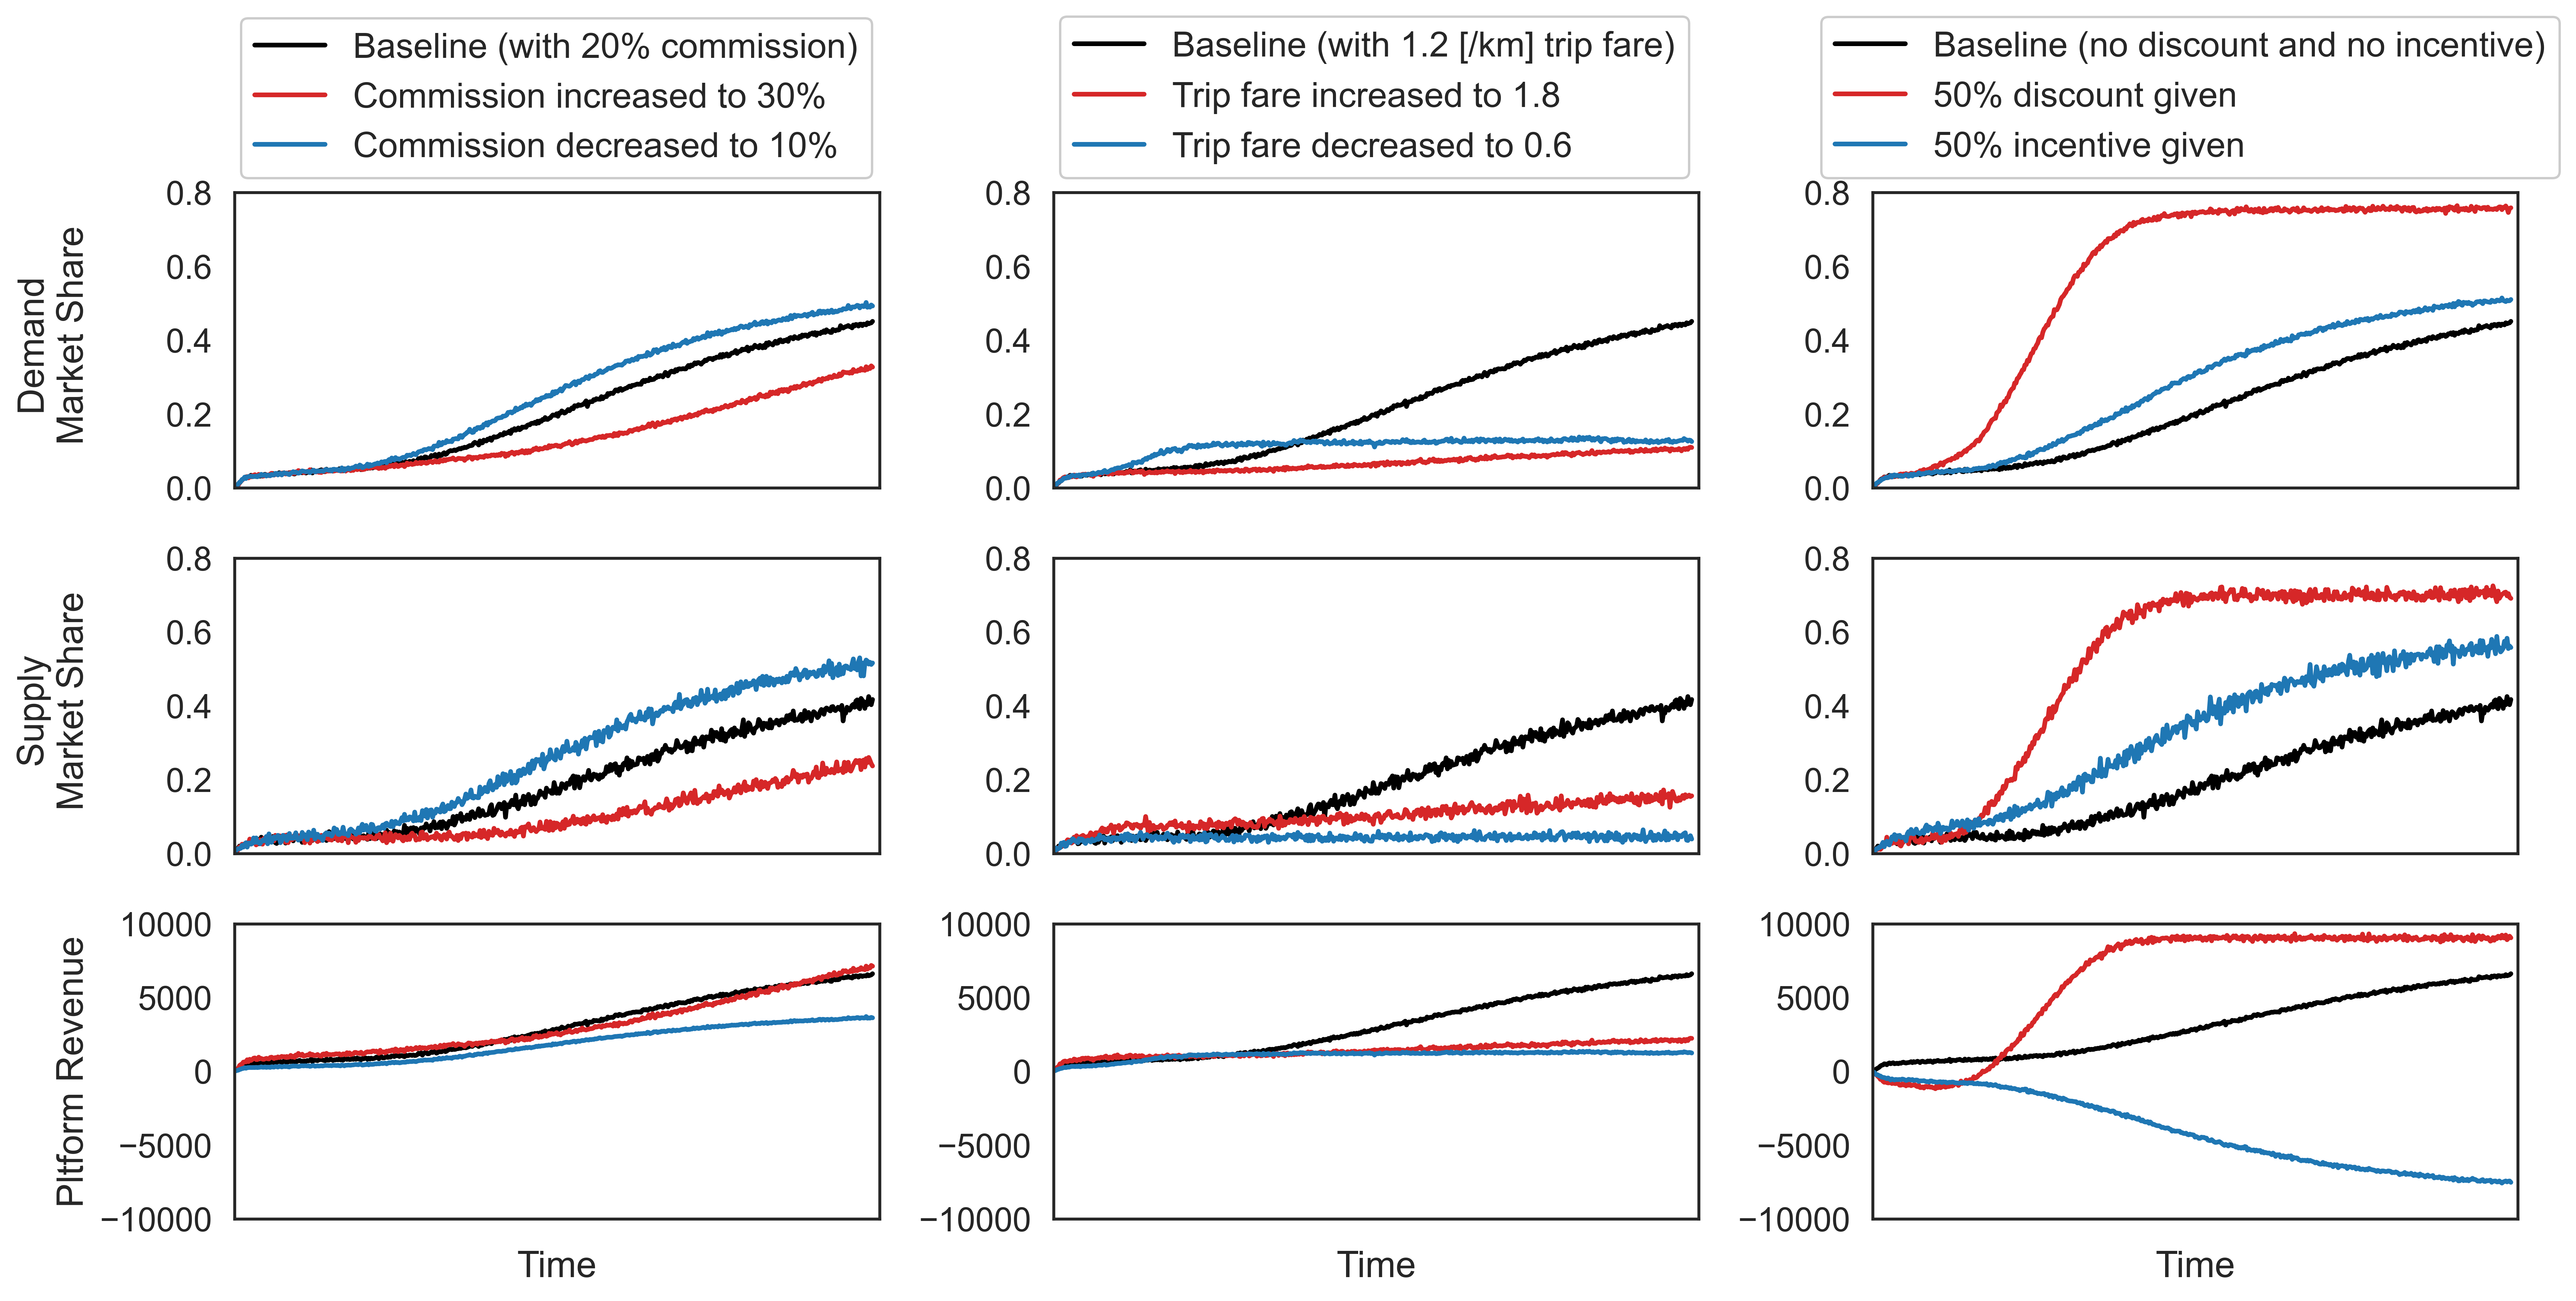

In [96]:
# with replicationssnoitacilperriment


# with sample for each experiment
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('white')
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
# sns.despine(left=True)

pallete = sns.color_palette("tab10")
c2=pallete[3]; c3=pallete[0]
lw = 2
# c2='darkred'; c3='darkblue'
start_date = pd.Timestamp('2012-07-01 00:00:00'); end_date = pd.Timestamp('2022-12-30 00:00:00')


for row in range(0,3):
    
    lx = [i for i in range(1,nD+1)]
    
    if row==0:
        n=10000; label='Demand side'
        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        # sns.lineplot(data=reps('baseline_demand'), x='date', y='OUT', label = 'Baseline (with 20% commission)', color='black', lw=0.5, ax=ax[row][0])
        sns.lineplot(x=df_c30_d.date, y=df_c30_d.OUT/n, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_d.date, y=df_c10_d.OUT/n, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (with 1.2 [/km] trip fare)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_d.date, y=df_f18_d.OUT/n, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_d.date, y=df_f06_d.OUT/n, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])

        sns.lineplot(x=df_d.date, y=df_d.OUT/n, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_d.date, y=df_disc50_d.OUT/n, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_incen50_d.date, y=df_incen50_d.OUT/n, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
    elif row==1:
        n = 1000; label='Supply side'
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c30_s.date, y=df_c30_s.OUT/n, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_s.date, y=df_c10_s.OUT/n, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (with 1.2 [/km] trip fare)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_s.date, y=df_f18_s.OUT/n, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_s.date, y=df_f06_s.OUT/n, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])
    
        sns.lineplot(x=df_s.date, y=df_s.OUT/n, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_s.date, y=df_disc50_s.OUT/n, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_incen50_s.date, y=df_incen50_s.OUT/n, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
    elif row==2:
        n = 1000; label='Platform'
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c30_d.date, y=df_c30_d.OUT*df_c30_d.plat_revenue, label = 'Commission increased to 30%', color=c2, lw=lw, ax=ax[row][0])
        sns.lineplot(x=df_c10_d.date, y=df_c10_d.OUT*df_c10_d.plat_revenue, label = 'Commission decreased to 10%', color=c3, lw=lw, ax=ax[row][0])
        
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (with 20% commission)', color='black', lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f18_d.date, y=df_f18_d.OUT*df_f18_d.plat_revenue, label = 'Trip fare increased to 1.8', color=c2, lw=lw, ax=ax[row][1])
        sns.lineplot(x=df_f06_d.date, y=df_f06_d.OUT*df_f06_d.plat_revenue, label = 'Trip fare decreased to 0.6', color=c3, lw=lw, ax=ax[row][1])
    
        sns.lineplot(x=df_d.date, y=df_d.OUT*df_d.plat_revenue, label = 'Baseline (no discount and no incentive)', color='black', lw=lw, ax=ax[row][2])
        sns.lineplot(x=df_disc50_d.date, y=df_disc50_d.OUT*df_disc50_d.plat_revenue, label = '50% discount given', color=c2, lw=lw, ax=ax[row][2])
        x = df_incen50_d.OUT*df_incen50_d.plat_revenue
        r = (x*100)/20; r = (r*80/100)*0.5; p = x-r
        sns.lineplot(x=df_incen50_d.date, y=p, label = '50% incentive given', color=c3, lw=lw, ax=ax[row][2])
        
        
    for col in range(0,3):
        ax[row][col].set(xlabel='', ylabel=None,xlim=(start_date, end_date), ylim=(0,0.8))
        ax[row][col].set(xlabel='', ylabel=None,xlim=(start_date, end_date), ylim=(0,0.8))
        ax[row][col].set(ylabel=None)
        ax[row][col].set_xticklabels([])
        ax[row][col].get_legend().set_visible(False)


ax[0][0].set(xlabel='', ylabel='Demand \n Market Share',xlim=(start_date, end_date), ylim=(0,0.8))
ax[1][0].set(xlabel='', ylabel='Supply \n Market Share',xlim=(start_date, end_date), ylim=(0,0.8))
ax[2][0].set(xlabel='Time', ylabel='Pltform Revenue',xlim=(start_date, end_date), ylim=(-10000,10000))
ax[2][1].set(xlabel='Time',xlim=(start_date, end_date), ylim=(-10000,10000))
ax[2][2].set(xlabel='Time',xlim=(start_date, end_date), ylim=(-10000,10000))

ax[0][0].legend(frameon=True, framealpha=1, fontsize=15, loc=(0.01,1.05))
ax[0][1].legend(frameon=True, framealpha=1, fontsize=15, loc=(0.01,1.05))
ax[0][2].legend(frameon=True, framealpha=1, fontsize=15, loc=(-0.08,1.05))

# fig.subplots_adjust(left=0.2, wspace=0.6)
fig.align_ylabels()


# ax[row][col].grid(axis='x')

# ax[row][col].set_title(label,fontweight='bold', loc='center',fontsize=10)
# ax[0][col].legend(frameon=True,framealpha=1, loc=(0.01,0.7))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
# ax[0][0].get_legend().set_visible(False)

plt.tight_layout()
# plt.savefig('9cells.png')